# Section 0: Loading Data
In this part, I will load packages and pre-process original data. A cleaned dataframe with selected variables for the model will be created. Data source and variable codebook: [Kaggle: Hateful Users on Twitter](https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter)

## 0.1 Loading

In [1]:
!pip3 install networkx==2.4

import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# load data
path = 'gdrive/My Drive/CIS545_2020/Project/users_neighborhood_anon.csv'
twitter = pd.read_csv(path, header=0)

In [4]:
# read edges file and create a graph object
graph = nx.Graph()
path = 'gdrive/My Drive/CIS545_2020/Project/users.edges'
G = nx.read_edgelist(path, nodetype=int)

# print the graph's info
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 100386
Number of edges: 2194979
Average degree:  43.7308


## 0.2 Pre-processing

### Variable Selection
I selected the following feature variables to study about the Twitter users' network in twitter_network dataframe:
1. **`hate`**: categorical, if the user was annotated as hateful, normal or not annotated
2. **`hate_neigh`** & **`normal_neigh`**: boolean, if the user was on the neighborhood of a hateful or normal user; "on the neighborhood" is defined as having retweeted other hateful/normal users
3. **`statuses_count`**, **`followers_count`**, **`followees_count`**, **`favorites_count`**, **`listed_count`**: int, the number of tweets, followers, followees and favorites a user has, and the number of lists a user is in
4. **`betweenness`**, **`engenvector`**, **`in_degree`**, **`out_degree`**: float, centrality measurements for each user in the retweet graph

The following variabels in twitter_activity dataframe will be used to study the users account activities:
1. **`tweet_num`**, **`retweet_num`**, **`quote_num`**: float, the percentate of direct tweets, retweets and quotes of an user
2. **`time_diff`**: float, average time difference between tweets
3. **`deleted`** & **`suspended`**: boolean, whether the account was suspended or deleted

I also selected the following content-based variables in twitter_content dataframe:
1. **`sentiment`** & **`subjectivity`**: float, average sentiment and subjectivity score of a user's tweets
2. **`baddies`**, **`mentions`**, **`hashtags_num`**: int, the number of bad words, mentions, hashtags used in tweets on average
3. **`hashtags`**: string, all hash tags used by the user

(I stored the variables in different dataframes for the convenience of operation in Section 2.)

In [0]:
# select variables
twitter_network = twitter[['user_id', 'hate', 'hate_neigh', 'normal_neigh', 
                      'statuses_count', 'followers_count', 'followees_count', 'favorites_count', 'listed_count', 
                      'betweenness', 'eigenvector', 'in_degree', 'out_degree']].copy()

twitter_activity = twitter[['user_id', 'hate',
                            'tweet number', 'retweet number','quote number','time_diff',
                            'is_50', 'is_63', 'is_50_2','is_63_2']].copy()

# rename some variables with spaces in their name
twitter_activity.rename(columns={'tweet number':'tweet_num', 'retweet number':'retweet_num','quote number':'quote_num',
                                 'is_50':'deleted', 'is_63':'suspended','is_50_2':'deleted_2', 'is_63_2':'suspended_2'}, inplace=True)

twitter_content = twitter[['user_id', 'hate',
                           'sentiment', 'subjectivity',
                           'baddies','mentions','number hashtags','hashtags', 'status length','number urls']].copy()
twitter_content.rename(columns={'number hashtags':'hashtag_num', 'number urls':'urls_num', 'status length':'tweet_len'}, inplace=True)

# set user_id as index
twitter_network.set_index('user_id',inplace=True)
twitter_activity.set_index('user_id',inplace=True)
twitter_content.set_index('user_id',inplace=True)

# drop null values
twitter_network.dropna(inplace=True)
twitter_activity.dropna(inplace=True)
twitter_content.dropna(inplace=True)

# Section 1: Introduction
In this project, by studying data on Twitter users, I intend to profile the “hateful” type of users with distinct network-based, activity-based or content-based features. The ultimate goal of this project is to apply machine learning techniques to build models predicting whether a non-labeled user can be potentially hateful based on his/her account activities and whether his/her account should be suspended. Ideally, I will compare the performances of different models using the users' network, activities and content data respectively, and conclude about what information facilitate the judgement of hateful users the best.



## 1.1 Hateful Users Definition
Hateful users in this project refers to the Twitter users that were annotated as hateful based on their tweets and hate speech spreading activities. Among all the records, 4951 of the accounts were annotated, taking roughly 5%, and 10.95% of the annotated were labeled as "Hateful Users".

In [6]:
twitter_network.groupby('hate').size()

hate
hateful      544
normal      4427
other      95415
dtype: int64

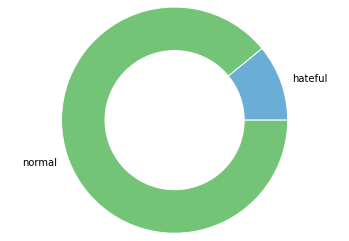

In [7]:
# Create colors
a, b=[plt.cm.Blues, plt.cm.Greens]
 
# Creat a simple donut plot to represent the persentage of annotated hateful
fig, ax = plt.subplots()
ax.axis('equal')
hatefulpie, _ = ax.pie([542, 4409], radius=1.3, labels=['hateful','normal'], colors=[a(0.5), b(0.5)] )
plt.setp(hatefulpie, width=0.5, edgecolor='white')
plt.show()

# Section 2: EDA
In this section, I will be doing Exploratory Data Analysis to grab distinct features of hateful users and find patterns of their activities and behavior based on their network connections, activity records and content of their tweets.

## 2.1 Network Analysis
In this part, I will analyze data on the retweeting community network and try to interpret patterns of hateful users' connections on Twitter.

### Graph
Before looking into particular features of the hateful-user group, one important thing is to understand how "hateful users" relate to each other. 
1. The following tabel shows that all hateful users have retweeted other hateful users hate speeches, while only 8.58% of normal users have interacted with hateful users. That is to say that hateful users have high-level of interaction within their heteful circle. 
2. The graph plot presents 150 edges (due to RAM limitation) of hateful users network graph. The interactions between hateful uers are intricate. It shows that, however, while all hateful users have conncetions to other hateful users, some of them are more involved in their "hate tweeting business" by connecting with more others within their type. Those key hateful users might be the ones that Twitter administrators should pay more attention to.

In [8]:
# calculate the percentage of users having hateful neighbors
hateful_neighbors = twitter_network.groupby('hate')['hate_neigh']
pd.concat([hateful_neighbors.value_counts(), round(hateful_neighbors.value_counts(normalize=True).mul(100),2)],
          axis=1, keys=('counts','percentage'))

counts  percentage
hate    hate_neigh                    
hateful True           544      100.00
normal  False         4047       91.42
        True           380        8.58
other   False        92868       97.33
        True          2547        2.67

In [0]:
# create a list of hateful users
hateful_user = twitter_network.loc[twitter_network.hate == 'hateful']
hateful_lst = list(hateful_user.index)
# locate the hateful users in the original graph
# both from-nodes and to-nodes are hateful users
hateful_edges = [edge for edge in G.edges() if edge[0] in hateful_lst and edge[1] in hateful_lst]

# create a graph including hateful users only
graph = nx.Graph()
# limited to first 150 records due to RAM limitation
graph.add_edges_from(hateful_edges[0:150])

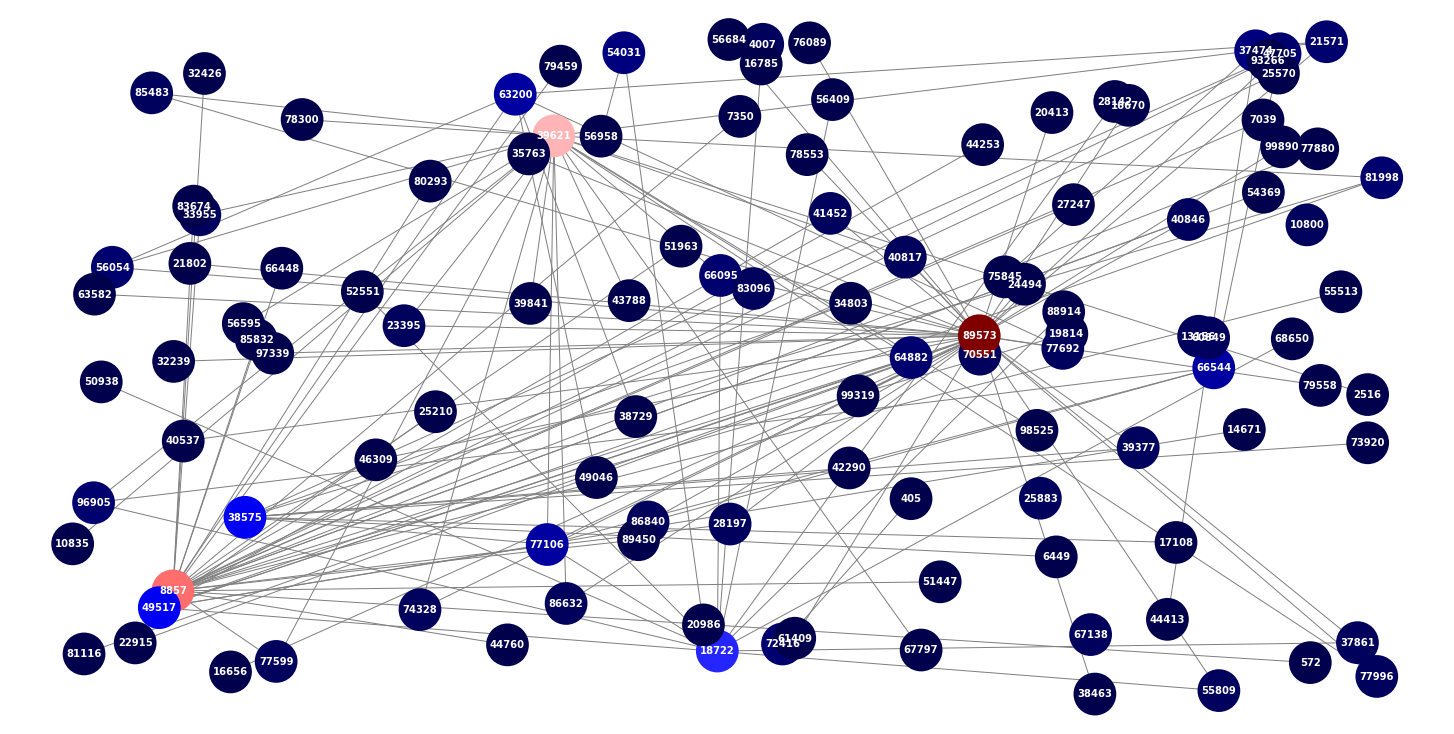

In [10]:
# create a dictionary of the count of the appearance of a user
nodes_list = [edge[0] for edge in graph.edges()]
nodes_list.extend([edge[1] for edge in graph.edges()])

color_lookup = {}
for i in nodes_list:
  if i not in color_lookup.keys():
    color_lookup[i] = nodes_list.count(i)

# create a color map based on the edges count
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.seismic)

# plot the graph
fig = plt.figure()
fig.set_size_inches(20, 10)

nx.draw_random(graph, nodelist=color_lookup, 
               with_labels=True, node_size=1500, 
               node_color=[mapper.to_rgba(i) 
                    for i in color_lookup.values()],
               node_shape="o", linewidths=4, font_size=10, 
               font_color="white", font_weight="bold", width=1, edge_color="grey")

### Centrality
Based on the following visualizations we can find that:
1. Hateful users averagely have less followers and followees than the normal group. While the Other group might include unannotated hateful users, I tend to not interpreting statistics on this group in detail.
2. The group of hateful users actually have higher centrality, especially high in_degree, in the retweet graph, meaning that they are potentially more influencial.
With less followers but higher centralities, hateful users can have quite a impact on the retweeting community in general.

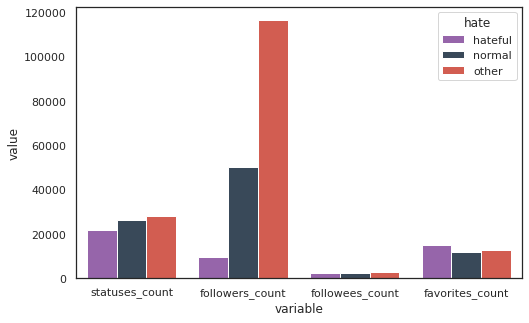

In [11]:
# plot users statuses count
df = twitter_network.groupby(['hate'])[['statuses_count','followers_count','followees_count','favorites_count']].mean()

# stack and reset the cross table
stacked = df.stack().reset_index().rename(columns={0:'value', 'level_1':'variable'})

# save a colormap for future use
flatui = ["#9b59b6", "#34495e", "#e74c3c", "#3498db", "#95a5a6", "#2ecc71"]
cmap = sns.color_palette(flatui)

# plot grouped bar chart
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("white")
sns.barplot(x=stacked.variable, y=stacked.value, hue=stacked.hate, palette=cmap)

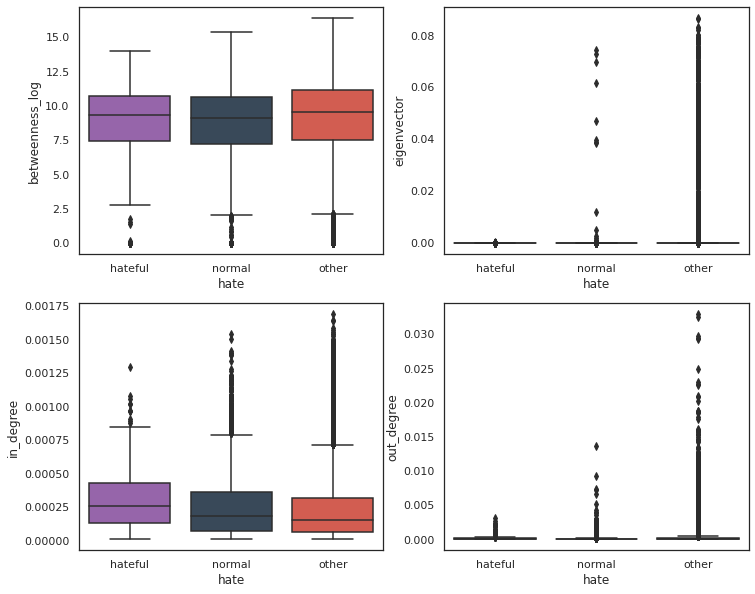

In [12]:
# log transform the betweenness variables
twitter_network['betweenness_log'] = np.log((twitter_network['betweenness']+1))

# box plot of the centrality measurements
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False)
sns.set_style("white")
sns.boxplot(x=twitter_network.hate, y=twitter_network.betweenness_log, palette=cmap, order=['hateful','normal','other'], ax=axes[0,0])
sns.boxplot(x=twitter_network.hate, y=twitter_network.eigenvector, palette=cmap, order=['hateful','normal','other'], ax=axes[0,1])
sns.boxplot(x=twitter_network.hate, y=twitter_network.in_degree, palette=cmap, order=['hateful','normal','other'], ax=axes[1,0])
sns.boxplot(x=twitter_network.hate, y=twitter_network.out_degree, palette=cmap, order=['hateful','normal','other'], ax=axes[1,1])

## 2.2 Activity Analysis
Since we found that hateful users have higher centrality in the retweering community that normal users, let's see if their account activity patterns reflect that. The conclusions are:
1. There are no distinct differences between hateful users and normal users activity log. Both of the two groups of users, tweet more than retweet as there are more accounts have more than 100 tweets and less than 100 retweets.
2. On average, hateful users have shorter gap between tweets, meaning that they tweet more frequently.
3. More normal-user accounts were deleted and more hateful-user accounts were suspended. Suspension is probably the most usual method used to regulate hateful users.

### Number of Tweets

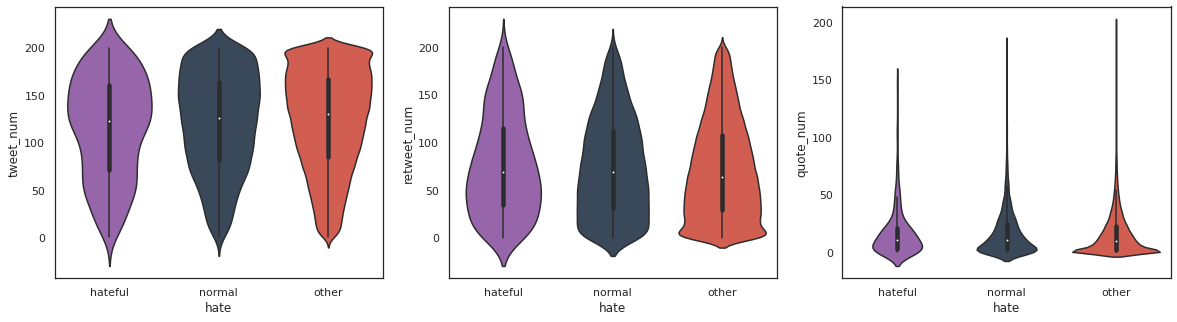

In [13]:
# violinplot of the accounts number of tweets, retweets and quotes

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=False)
sns.set_style("whitegrid")
sns.violinplot(x=twitter_activity.hate, y=twitter_activity.tweet_num, palette=cmap, order=['hateful','normal','other'], ax=axes[0])
sns.violinplot(x=twitter_activity.hate, y=twitter_activity.retweet_num, palette=cmap, order=['hateful','normal','other'], ax=axes[1])
sns.violinplot(x=twitter_activity.hate, y=twitter_activity.quote_num, palette=cmap, order=['hateful','normal','other'], ax=axes[2])

### Frequency

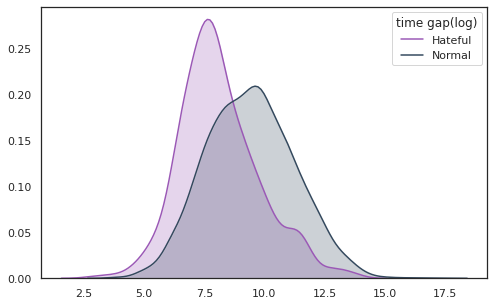

In [14]:
# log transform time difference
twitter_activity['time_log'] = np.log((twitter_activity['time_diff']+1))
time_diff1 = twitter_activity.loc[twitter_activity.hate == 'hateful']['time_log']
time_diff2 = twitter_activity.loc[twitter_activity.hate == 'normal']['time_log']

# density plot
sns.set_style("white")
p1=sns.kdeplot(time_diff1, shade=True, color="#9b59b6")
p1=sns.kdeplot(time_diff2, shade=True, color="#34495e")
plt.legend(title='time gap(log)', loc='upper right', labels=['Hateful', 'Normal'])

### Account management

In [0]:
# to plot the hateful/normal percentage of deleted or suspended accounts
# annotated accounts deleted or suspended before 12/12/17
deleted = twitter_activity.loc[(twitter_activity.deleted == True) & (twitter_activity.hate != 'other')]
deleted_1 = deleted.groupby('hate')['deleted'].count()
suspended = twitter_activity.loc[(twitter_activity.suspended == True) & (twitter_activity.hate != 'other')]
suspended_1 = suspended.groupby('hate')['suspended_2'].count()

# annotated accounts deleted or suspended before 14/01/18
deleted2 = twitter_activity.loc[(twitter_activity.deleted_2 == True) & (twitter_activity.hate != 'other')]
deleted_2 = deleted2.groupby('hate')['deleted_2'].count()
suspended2 = twitter_activity.loc[(twitter_activity.suspended_2 == True) & (twitter_activity.hate != 'other')]
suspended_2 = suspended2.groupby('hate')['suspended_2'].count()

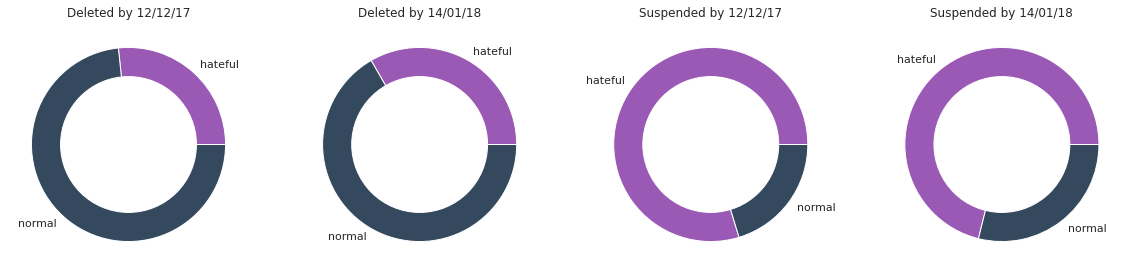

In [16]:
# create donut plot cuz I'd love to have some donut now
circle=plt.Circle((0,0), 0.7, color='white')
circle2=plt.Circle((0,0), 0.7, color='white')
circle3=plt.Circle((0,0), 0.7, color='white')
circle4=plt.Circle((0,0), 0.7, color='white')

plt.figure(figsize=(20,5))

ax1 = plt.subplot2grid((1,4),(0,0))
plt.pie(deleted_1, labels=deleted_1.index, colors=flatui)
plt.title('Deleted by 12/12/17')
plt.gcf().gca().add_artist(circle)

ax2 = plt.subplot2grid((1,4),(0,1))
plt.pie(deleted_2, labels=deleted_2.index, colors=flatui)
plt.title('Deleted by 14/01/18')
plt.gcf().gca().add_artist(circle2)

ax3 = plt.subplot2grid((1,4),(0,2))
plt.pie(suspended_1, labels=suspended_1.index, colors=flatui)
plt.title('Suspended by 12/12/17')
plt.gcf().gca().add_artist(circle3)

ax4 = plt.subplot2grid((1,4),(0,3))
plt.pie(suspended_2, labels=suspended_2.index, colors=flatui)
plt.title('Suspended by 14/01/18')
plt.gcf().gca().add_artist(circle4)

plt.show()

## 2.3 Content Analysis
Besides users' network connections and activities, the content of their tweets can also tell us a lot about the users. Reading from the result, we can see that:
1. Hateful users have both lower sensitivity and subjectivity scores on average tahn normal users.
2. On average, hateful users use more bad words, more mentions, less hashtags and less urls than normal users. The average lengths of hateful users' and normal users' tweets are about the same.

### Sentiment

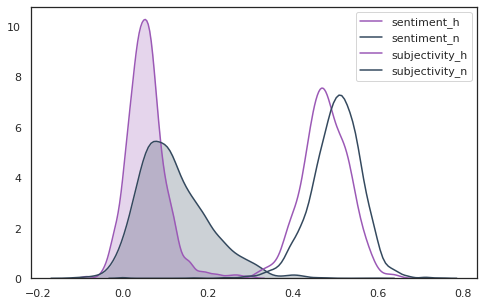

In [17]:
senti1 = twitter_content.loc[twitter_content.hate == 'hateful']['sentiment']
senti2 = twitter_content.loc[twitter_content.hate == 'normal']['sentiment']
subjc1 = twitter_content.loc[twitter_content.hate == 'hateful']['subjectivity']
subjc2 = twitter_content.loc[twitter_content.hate == 'normal']['subjectivity']

# density plot
sns.set_style("white")
p1=sns.kdeplot(senti1, shade=True, color="#9b59b6")
p1=sns.kdeplot(senti2, shade=True, color="#34495e")
p1=sns.kdeplot(subjc1, shade=False, color="#9b59b6")
p1=sns.kdeplot(subjc2, shade=False, color="#34495e")
p1.legend(labels = ['sentiment_h','sentiment_n','subjectivity_h','subjectivity_n'])

### Wording

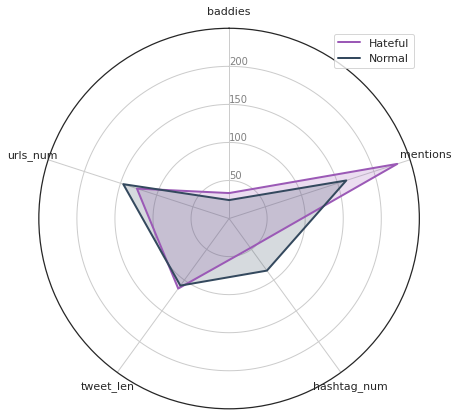

In [18]:
# create a dendrogram to compare the mean value of
# hateful/normal users' content counts

# a df calculate the mean
df = twitter_content.groupby(['hate'])[['baddies','mentions','hashtag_num', 'tweet_len', 'urls_num']].mean()
df = df.reset_index()
df = df.drop(columns=['hate'])

from math import pi
categories=list(df)
N = len(categories)

# initialize the plot
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
fig = plt.figure()
fig.set_size_inches(7,7)
ax = fig.add_subplot(111, polar=True)

# set the first ax on top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# set x and y axises
plt.xticks(angles[:-1], categories)
ax.set_rlabel_position(0)
plt.yticks([50,100,150,200], ['50','100','150','200'], color="grey", size=10)
plt.ylim(0,250)

# plot hateful users' data
values=df.loc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values,  color="#9b59b6", linewidth=2, linestyle='solid')
ax.fill(angles, values, "#9b59b6", alpha=0.2)

# plot normal users' data
values=df.loc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, color="#34495e", linewidth=2, linestyle='solid')
ax.fill(angles, values, "#34495e", alpha=0.2)
ax.legend(labels= ['Hateful','Normal'])

# Section 3: Modeling
The classification task for this project is to build models that can automate the annotation process for the unannotated "other" records. The training and testing data will be the instances that were already labeled manually.

## 3.1 Preparing Dataset
Since we have explored the relevancy of some variabels and now know in which terms hateful users may differentiate from normal users, I will select some of the most distinct features to build the training dataset and testing dataset to be used for the classification task.

### Feature Selection
From the correlation heat map, we can see that the "hateful" label is in very strong correlationships with hate_neigh and suspended.

In [0]:
# select features based on previous analysis
twitter_data = twitter[['hate','hate_neigh','followers_count','time_diff','sentiment','subjectivity',
                        'is_50_2','is_63_2','mentions','number hashtags']].copy()
twitter_data.rename(columns={'is_50_2':'deleted', 'is_63_2':'suspended','number hashtags':'hashtags'}, inplace=True)
twitter_data.dropna(inplace=True)

# select only annotated records
twitter_data = twitter_data.loc[twitter_data.hate!='other']
twitter_data.reset_index(drop=True, inplace=True)

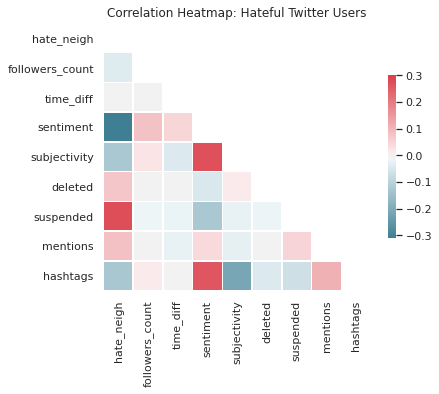

In [20]:
sns.set(style="white")

# generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)))

# compute the correlation matrix
corr = twitter_data.corr(method='pearson')

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(6,6))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: Hateful Twitter Users")
plt.show()

### Label Processing

In [0]:
# turn the categorical hate variable into a boolean
twitter_data['hateful'] = twitter_data['hate'].apply(lambda x: x == 'hateful')
twitter_data.drop(columns=['hate'], inplace=True)

# define label and feature columns
label = twitter_data['hateful']
features = twitter_data.drop(columns=['hateful'])
features = pd.get_dummies(features)

## 3.2 Model Training

### Define Modeling Function
In this section, for later use, I will define:
1. A k-fold modeling function to work on the un-transformed original training data
2. A grid search modeling function to tune hyperparameters and find the best model

After comparison, Random Forest performs the best compared to single decision trees and logistic regression with this dataset on average and can reach accuracy scores as high as 91-92% and kappa score around 0.6-0.7 which is quite good.

In [0]:
def k_folds_model(X, y, classifiers, metrics, kf_num, matrix_labels):
  
  # use dataframe to store outcomes
  records = []

  # iterate over each classifier
  for classifier_name, classifier in classifiers.items():

    kf = KFold(n_splits=kf_num, shuffle=True)

    # split the training set into k folds and build models through cross-validation
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):

      fold_record = {'Classifier':classifier_name,
                     'Fold_num': fold_num}

      # split train set and test set within each fold
      X_train = X.iloc[train_index]
      X_test = X.iloc[test_index]
      y_train = y.iloc[train_index]
      y_test = y.iloc[test_index]

      # train the model
      model = classifier.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # calculate the metrics
      for (metric_name, metric) in metrics.items():
        result = metric(y_test, y_pred)
        fold_record[metric_name] = round(result, 4)

      # ignore UndefinedMetricWarning caused by ill-preforming single nominal features
      warnings.filterwarnings("ignore")

      # store the results of k folds into a dataframe
      records.append(fold_record)
    records_df = pd.DataFrame(records)
  
  return records_df

In [0]:
def grid_search(X, y, estimator, test_size, param_grid, metrics, matrix=True):

  # split train and test set
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=123)

  # perform grid search and find the best estimator
  grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid)
  grid_search.fit(x_train, y_train)
  
  # predict using the best set of parameters
  best_grid = grid_search.best_estimator_
  y_pred = best_grid.predict(x_test)

  # print results
  print(f"Best Parameters: {grid_search.best_params_}")
  for (metric_name, metric) in metrics.items():
    result = round(metric(y_test, y_pred),4)
    print(f"{metric_name}: {result}")

  if matrix == True:
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix, ["Normal", "Hateful"]).plot(values_format='.4g')
    plt.show()

### K-fold Classifier Comparison

In [24]:
# defin classifiers and metrics
classifiers = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", multi_class='ovr', max_iter=10000, random_state=123),
    "Random Forest":RandomForestClassifier(n_estimators=100)
}

metrics = {
    "Accuracy" : lambda y_test,y_pred: 100*accuracy_score(y_test,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score,
    "F"        : f1_score
}

# train the models
matrix_labels = ['hateful','normal']
k_fold_classifiers = k_folds_model(features, label, classifiers, metrics, 10, matrix_labels)

# calculate the mean result of the metrics
result = k_fold_classifiers.groupby('Classifier')[['Accuracy','Kappa',"Precision","Recall","F"]].mean()
result.sort_values(by=['Kappa'], ascending=False,inplace=True)
result

,Accuracy,Kappa,Precision,Recall,F
Classifier,,,,,
Random Forest,92.99129,0.64753,0.66845,0.70866,0.68694
Decision Tree,91.94147,0.58348,0.63657,0.62586,0.62851
Logistic Regression,89.35549,0.08089,0.23442,0.09730,0.08661


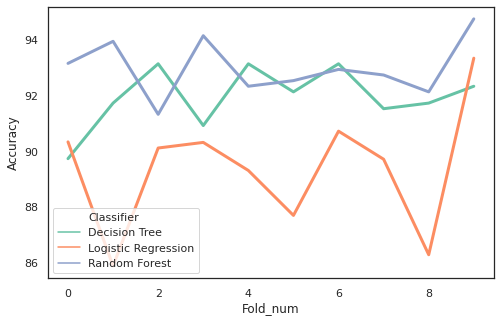

In [25]:
sns.lineplot(x='Fold_num', y='Accuracy', hue='Classifier', data=k_fold_classifiers, palette="Set2", linewidth=3)

### Grid Search

#### 1) Random Forest
The best random forest model can reach about 91.83% accuracy and 0.57 kappa.



Best Parameters: {'max_depth': 20, 'max_features': 2, 'n_estimators': 100}
Accuracy: 91.8264
Kappa: 0.5775
Precision: 0.6569
Recall: 0.5929
F: 0.6233


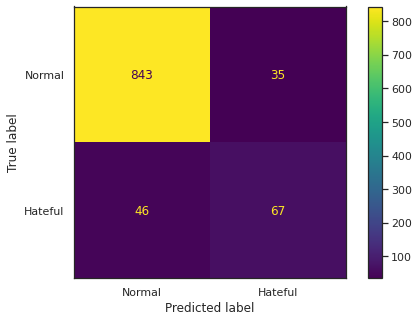

In [26]:
param_grid = {
    'max_depth': [20, 25, 30],
    'max_features': [2, 3, 4, 5],
    'n_estimators': [100, 200, 230, 250, 280, 300]
}

estimator = RandomForestClassifier(random_state=123)
grid_search(features, label, estimator, 0.2, param_grid, metrics)

#### 2) Decision Tree Visualization
A single decision tree model performs at 90% of accuracy with only one leaf. The very high recall score indicates that the model is considering all of the "suspicious hateful" as "hatefil". While the cost of missing out a hateful twitter user is not greater than the cost of making an mistake about that, the decision tree model is not very ideal in this term. Also, since the tree is super simple, meaning that there are features (possibly the "hateful_neigh" or "suspended") of very strong correlation with the prediction.

Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_impurity_decrease': 0.0, 'splitter': 'random'}
Accuracy: 91.5237
Kappa: 0.6831
Precision: 0.5736
Recall: 1.0
F: 0.729


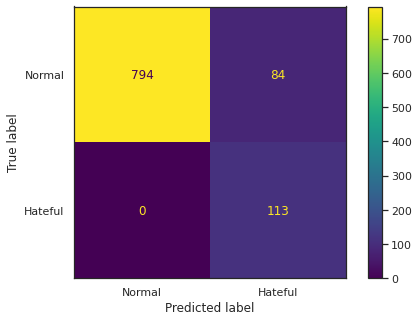

In [27]:
param_grid = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'], 
    'max_depth': [2,3,4], 
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}

metrics = {
    "Accuracy" : lambda y_test,y_pred: 100*accuracy_score(y_test,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score,
    "F"        : f1_score
}

estimator = DecisionTreeClassifier(random_state=123)
grid_search(features, label, estimator, 0.2, param_grid, metrics)

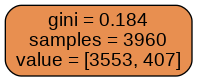

In [28]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# build the decision tree model using the best set of parameters
clf = DecisionTreeClassifier(criterion="gini", max_depth = 4, min_impurity_decrease = 0.1)
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=1)
clf = clf.fit(x_train,y_train)

# plot the decision tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Hateful Twitter Users Decision Tree.png')
Image(graph.create_png())

### PCA
Due to the influence of highly correlated variables, the classfication task was a little bit too simple (and boring). Using the "suspended" variable also undermines the effectiveness of the model to predict and facilitate the decision of whether or not one's account activity should be regulated.

In this section, I will not be using features directly related with users' activity rather use content based (NLP results) features such as the users' late 200 tweets' empathy score and glove vectors. Give the number of feature columns, I will use Principal Component Analysis to reduce the dimensionality of the data first.

#### 1) Classification: Hateful
This following model predicts the label using logistic regression. This model performed almost as well as the random forest model using activity based features with 92% accuracy and 0.5 Kappa. 

In [29]:
# select golve vector and empath score features to build new training and testing dataset
all_features = list(twitter.columns)

# 'hate' will be used in this section and 'retweet number' is for the next
glove_emp = ['hate','retweet number']
glove_emp.extend([i for i in all_features if i.endswith('_glove') and i.startswith('c_')==False 
                  or i.endswith('_empath') and i.startswith('c_')==False])

twitter_ge = twitter[glove_emp].copy()
twitter_ge = twitter_ge.loc[twitter_ge.hate!='other']
twitter_ge['hate'] = twitter_ge['hate'].apply(lambda x: x == 'hateful')
twitter_ge.rename(columns={'retweet number':'retweet_num'}, inplace=True)
twitter_ge.dropna(inplace=True)

# select only annotated records
twitter_ge.reset_index(drop=True, inplace=True)
twitter_ge.shape

(4952, 496)

In [0]:
# define label and feature columns
label = twitter_ge['hate']
features = twitter_ge.drop(columns=['hate','retweet_num'])
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.4, random_state=1)

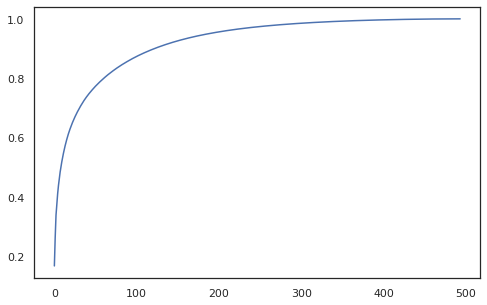

In [31]:
# use PCA to reduce number of dimensions
x_train = StandardScaler().fit_transform(x_train)
pca = PCA(n_components=494)
pca.fit_transform(x_train)

# plot the explained_variance_ratio
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
pc_vs_variance
plt.plot(pc_vs_variance)

In [0]:
# PCA transform
pca = PCA(n_components=300)
pca_model = pca.fit(x_train)
x_train = pca_model.transform(x_train)
x_test = StandardScaler().fit_transform(x_test)
x_test = pca.transform(x_test)

Best Parameters: {'penalty': 'none'}
Accuracy: 92.0283
Kappa: 0.5127


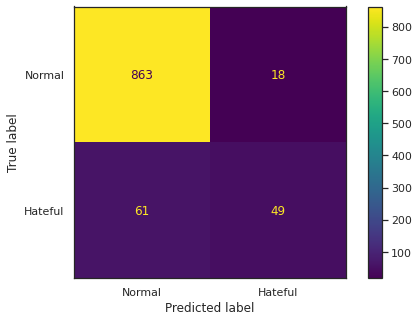

In [33]:
param_grid = {
    'penalty': ['l1','l2','elasticnet','none']
}

metrics = {
    "Accuracy" : lambda y_test,y_pred: 100*accuracy_score(y_test,y_pred),
    "Kappa"    : cohen_kappa_score
}

# use random regressor to predict the number of retweets based on the users late 200 tweets
estimator = LogisticRegression(random_state=123)
grid_search(features, label, estimator, 0.2, param_grid, metrics, matrix=True)

#### 2) Regression: Number of Retweet
So in this section, I tried to use content based empath scores and glove vectors to predict the user's number of retweets. The RMSE of the final model with selected parameters is 41.43, smaller than the standard deviation of the retweet numbers.

In [0]:
# define label and feature columns
label = twitter_ge['retweet_num']
features = twitter_ge.drop(columns=['retweet_num','hate'])
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.4, random_state=1)

# PCA transform based on the n_components as above
pca = PCA(n_components=300)
pca_model = pca.fit(x_train)
x_train = pca_model.transform(x_train)
x_test = StandardScaler().fit_transform(x_test)
x_test = pca.transform(x_test)

In [171]:
param_grid = {
    'max_depth': [10, 15, 20],
    'max_features': [3, 5, 9],
    'n_estimators': [50, 100, 200]
}

metrics = {
    'RMSE': lambda y_test,y_pred: np.sqrt(mean_squared_error(y_test, y_pred))
}

# use random regressor to predict the number of retweets based on the users late 200 tweets
estimator = RandomForestRegressor(n_jobs=-1, random_state=123)
grid_search(features, label, estimator, 0.2, param_grid, metrics, matrix=False)

Best Parameters: {'max_depth': 20, 'max_features': 9, 'n_estimators': 200}
RMSE: 41.4311


In [173]:
twitter_ge['retweet_num'].std()

51.517039637328054

# Section 4: Challenges
In this project, I explored hateful twitter users' network, activity and content attributes. I found that the hateful users on Twitter maintain high level of interactions with each other, have less followers on average, but higher centrality in the retweeting community. Some key users play the most active role in the hateful ecosystem and can somehow impact the entire cyber-environment on Twitter.

During the process, I found the graph traversal to be particularly challenging given the size of the dataset. I also find that the logic of the classification task to be a little bit problematic if the variables of decisive variables, such as whether the user has hateful neighbors or whether the account was suspended or not, are included in the model. In that case, the model can only be applied to annotated the unannotated instances in the data set, but can not be applied to a wider range of application to facilitate the decision of whether to suspend an account or not. To address that problem, I also used content-based glove vectors and empathy scores to build models for prediction tasks.


# Section 5: Future Direction
The application of the models can be broad. Knowing which users can potentially be hateful and may spread hate speeches can help Twitter administrators to regulate bad activities such as online abuses and cyber violence. Maintaining a good platform environment can eventually help with Twitter's operation and revenue.

The future direction of the study on hateful twitter users can be looking deeper into the hateful users' network and find the key hateful "influencers" and study the impact of their activity and hate speeches on other normal users and on the platform.

## **Thanks for reading:) Take care and stay safe!**